# Insurance Claim Prediction


## Python Imports
Run this section to import all the needed libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

## Load the data
This section loads the dataset and prints the first 5 entries.

In [6]:
# Load the provided housing datasets
data = pd.read_csv('data/train.csv')
claims = data['loss']
features = data.drop('loss', axis = 1)

print features.head()

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9    ...        cont5  \
0   1    A    B    A    B    A    A    A    A    B    ...     0.310061   
1   2    A    B    A    A    A    A    A    A    B    ...     0.885834   
2   5    A    B    A    A    B    A    A    A    B    ...     0.397069   
3  10    B    B    A    B    A    A    A    A    B    ...     0.422268   
4  11    A    B    A    B    A    A    A    A    B    ...     0.704268   

      cont6     cont7    cont8    cont9   cont10    cont11    cont12  \
0  0.718367  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646   
1  0.438917  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307   
2  0.289648  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424   
3  0.440945  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570   
4  0.178193  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213   

     cont13    cont14  
0  0.822493  0.714843  
1  0.611431  0.304496  
2  0.195709  0.774425  
3  0.605077  0.602642  
4 

## Explore the Data
To get a better understanding of the provided data, some analysis and visualization is provided.
### Statistical Analysis
This section shall detail some of the statistical properties of the target feature.

In [12]:
#Minimum claim of the data
minimum_claim = np.amin(claims)

#Maximum claim of the data
maximum_claim = np.amax(claims)

#Mean claim of the data
mean_claim = np.mean(claims)

#Median price of the data
median_claim = np.median(claims)

#25% Quantile
percentile_25 = np.percentile(claims, 25)

#50% Percentile
percentile_50 = np.percentile(claims, 50)

#75% Quantile
percentile_75 = np.percentile(claims, 75)

#Standard deviation of the claims in the data
std_claim = np.std(claims)

# Show the calculated statistics
print "Statistics for Insurence claims dataset:\n"
print "Minimum claim: ${:,.2f}".format(minimum_claim)
print "Maximum claim: ${:,.2f}".format(maximum_claim)
print "Mean claim: ${:,.2f}".format(mean_claim)
print "Median claim ${:,.2f}".format(median_claim)
print "25% percentile ${:,.2f}".format(percentile_25)
print "50% percentile ${:,.2f}".format(percentile_50)
print "75% percentile ${:,.2f}".format(percentile_75)
print "Standard deviation of claims: ${:,.2f}".format(std_claim)

Statistics for Insurence claims dataset:

Minimum claim: $0.67
Maximum claim: $121,012.25
Mean claim: $3,037.34
Median claim $2,115.57
25% percentile $1,204.46
50% percentile $2,115.57
75% percentile $3,864.05
Standard deviation of claims: $2,904.08


This information helps to give context to future predictions. Also the Minimum of $0.67 and Maximum of $121,012.25, are already showing that some outliers will have to be removed.

### Visualizing the Data

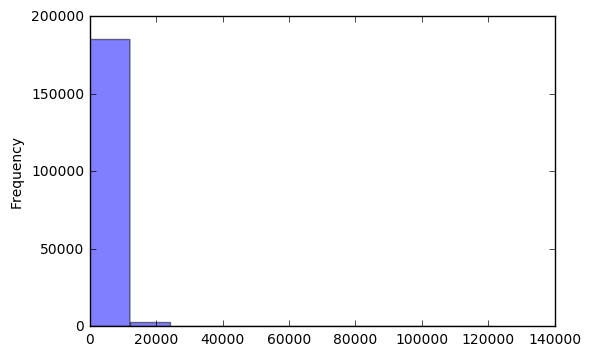

In [24]:
claims.plot(kind='hist', alpha=0.5)

This scatterplot matrix helps to get a better understanding of the data. One can already see correlations, that can be used to trim down the dataset using feature selection. Most notably are cont11 <-> cont12, which seem to correlate strictly linearly. Some other correlations can also be seen, but not as clearly, like cont1 <-> cont9.
The target feature "loss" is left skewed and might need normalization for better results from the regression model.

For performance reasons, the data is split to only contain the first 500 points. **It might still take a while to compute!**

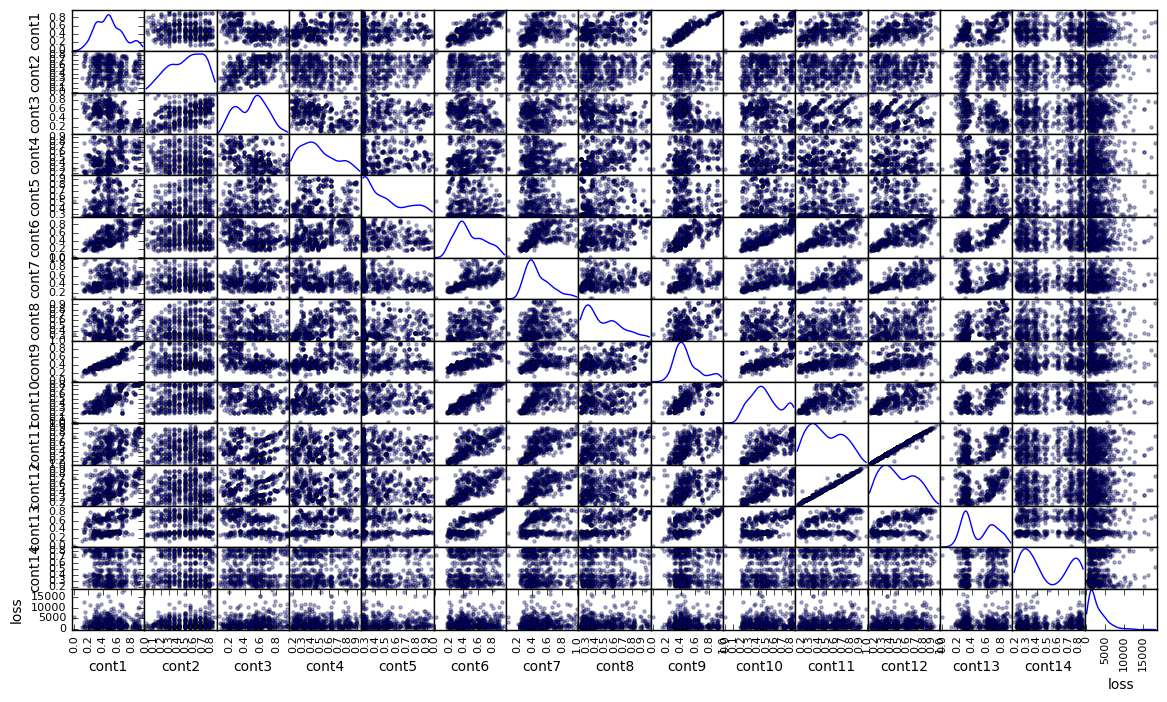

In [22]:
scatterdata = data[:500].drop("id", axis = 1)

pd.scatter_matrix(scatterdata, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

This is the scatterplot matrix over **ALL** the datapoints. It can be produced by the following code:

**THIS WILL TAKE QUITE A LONG TIME**

In [26]:
#Activate if wished. Again: This will be slow
if False:
    pd.scatter_matrix(data.drop('id', axis = 1), alpha = 0.3, figsize = (14,8), diagonal = 'kde');

<img src="files/img/scatterplot_all.png">